# Cyanobacteria Toxicity Classification Notebook

## 1. Setup & Configuration

In [16]:
import os
from datetime import date
import subprocess
import yaml
import pandas as pd
import torch
from torchvision.models import ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import models, datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from src.config_utils import load_config
from PIL import Image
import math
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)

config = load_config(path='../configs/config_finetune_resnet18.yaml')

FIG_OUT  = os.path.join('..','outputs','figures', 'all', 'finetune_resnet18')

# Génération du Run ID: date + git hash
today = date.today().isoformat()
commit = subprocess.check_output(["git","rev-parse","--short","HEAD"]).decode().strip()
run_id = f"{today}_{commit}"

print("Run ID :", run_id)

Run ID : 2025-07-08_0ef9650


## 2. Data Preparation

In [2]:
# Define transforms based on config
data_cfg = config['augmentation']
train_transform = transforms.Compose([
    transforms.Resize(tuple(data_cfg['resize'])),
    transforms.RandomHorizontalFlip() if data_cfg['horizontal_flip'] else transforms.Lambda(lambda x: x),
    transforms.RandomRotation(data_cfg['rotation']),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_cfg['normalization']['mean'], std=data_cfg['normalization']['std'])
])

# Create dataset
dataset = datasets.ImageFolder(root=os.path.join( '../', config['data']['path']), transform=train_transform)

# Split into train/val
total = len(dataset)
train_size = int(config['data']['train_split'] * total)
val_size = total - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_set, batch_size=config['data']['batch_size'], shuffle=True, num_workers=config['data']['num_workers'])
val_loader   = DataLoader(val_set,   batch_size=config['data']['batch_size'], shuffle=False, num_workers=config['data']['num_workers'])

## 3. Model Definition

In [3]:
model_cfg = config['model']
model = getattr(models, model_cfg['name'])(weights=ResNet18_Weights.DEFAULT)
if hasattr(model, 'fc'):
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, model_cfg['num_classes'])
elif hasattr(model, 'classifier'):
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, model_cfg['num_classes'])
model = model.to(config['training']['device'])


## 4. Training Loop

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=float(config['training']['learning_rate']), weight_decay=float(config['training']['weight_decay']))

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(loader, desc='Train'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc  = correct.double() / total
    return epoch_loss, epoch_acc.item()


def eval_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds  = []
    all_probs  = []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Val'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            probs  = torch.softmax(outputs, dim=1)[:, 1]
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    epoch_loss = running_loss / total
    epoch_acc  = correct.double() / total
    return (
        epoch_loss,
        epoch_acc.item(),
        np.array(all_labels),
        np.array(all_preds),
        np.array(all_probs)
    )

In [5]:
# Training and validation
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'val_roc_auc': [],  'val_avg_prec': []
}
for epoch in range(config['training']['epochs']):
    print(f"Epoch {epoch+1}/{config['training']['epochs']}")
    t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer, config['training']['device'])
    v_loss, v_acc, y_true, y_pred, y_prob = eval_model(model, val_loader, criterion, config['training']['device'])
    history['train_loss'].append(t_loss)
    history['val_loss'].append(v_loss)
    history['train_acc'].append(t_acc)
    history['val_acc'].append(v_acc)
    roc_auc   = roc_auc_score(y_true, y_prob)
    avg_prec  = average_precision_score(y_true, y_prob)
    history['val_roc_auc'].append(roc_auc)
    history['val_avg_prec'].append(avg_prec)
    print(f"Train loss: {t_loss:.4f}, acc: {t_acc:.4f} | Val loss: {v_loss:.4f}, acc: {v_acc:.4f} | ROC AUC: {roc_auc:.3f}, AP: {avg_prec:.3f}")

Epoch 1/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.21s/it]


Train loss: 0.3756, acc: 0.8114 | Val loss: 0.3152, acc: 0.8571 | ROC AUC: 0.959, AP: 0.972
Epoch 2/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]


Train loss: 0.2206, acc: 0.9131 | Val loss: 0.2636, acc: 0.8908 | ROC AUC: 0.970, AP: 0.977
Epoch 3/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]


Train loss: 0.1905, acc: 0.9364 | Val loss: 0.2126, acc: 0.9076 | ROC AUC: 0.976, AP: 0.982
Epoch 4/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.21s/it]


Train loss: 0.1225, acc: 0.9513 | Val loss: 0.1966, acc: 0.9160 | ROC AUC: 0.979, AP: 0.985
Epoch 5/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.21s/it]


Train loss: 0.0911, acc: 0.9703 | Val loss: 0.1692, acc: 0.9244 | ROC AUC: 0.985, AP: 0.989
Epoch 6/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.25s/it]


Train loss: 0.0985, acc: 0.9619 | Val loss: 0.1995, acc: 0.9244 | ROC AUC: 0.978, AP: 0.983
Epoch 7/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.24s/it]


Train loss: 0.0856, acc: 0.9682 | Val loss: 0.1950, acc: 0.9244 | ROC AUC: 0.982, AP: 0.987
Epoch 8/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.23s/it]


Train loss: 0.0883, acc: 0.9746 | Val loss: 0.2750, acc: 0.9076 | ROC AUC: 0.978, AP: 0.985
Epoch 9/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.21s/it]


Train loss: 0.0505, acc: 0.9831 | Val loss: 0.1214, acc: 0.9664 | ROC AUC: 0.991, AP: 0.993
Epoch 10/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.21s/it]


Train loss: 0.0371, acc: 0.9852 | Val loss: 0.1757, acc: 0.9412 | ROC AUC: 0.986, AP: 0.991
Epoch 11/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]


Train loss: 0.0909, acc: 0.9640 | Val loss: 0.1870, acc: 0.9328 | ROC AUC: 0.989, AP: 0.992
Epoch 12/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]


Train loss: 0.0962, acc: 0.9703 | Val loss: 0.1286, acc: 0.9412 | ROC AUC: 0.993, AP: 0.995
Epoch 13/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]


Train loss: 0.0354, acc: 0.9873 | Val loss: 0.1441, acc: 0.9580 | ROC AUC: 0.989, AP: 0.992
Epoch 14/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.21s/it]


Train loss: 0.0284, acc: 0.9873 | Val loss: 0.1671, acc: 0.9496 | ROC AUC: 0.988, AP: 0.990
Epoch 15/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.21s/it]


Train loss: 0.0608, acc: 0.9725 | Val loss: 0.1324, acc: 0.9580 | ROC AUC: 0.990, AP: 0.992
Epoch 16/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]


Train loss: 0.0528, acc: 0.9788 | Val loss: 0.1259, acc: 0.9664 | ROC AUC: 0.991, AP: 0.994
Epoch 17/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]


Train loss: 0.0456, acc: 0.9831 | Val loss: 0.2029, acc: 0.9244 | ROC AUC: 0.989, AP: 0.992
Epoch 18/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.23s/it]


Train loss: 0.0532, acc: 0.9915 | Val loss: 0.2226, acc: 0.9160 | ROC AUC: 0.982, AP: 0.987
Epoch 19/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]


Train loss: 0.0420, acc: 0.9831 | Val loss: 0.1717, acc: 0.9496 | ROC AUC: 0.985, AP: 0.988
Epoch 20/20


Val: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]

Train loss: 0.0441, acc: 0.9873 | Val loss: 0.1566, acc: 0.9412 | ROC AUC: 0.988, AP: 0.990


In [6]:
hist_path = '../outputs/checkpoints/all/finetune_resnet18/history_finetune_resnet18.pkl'
pd.to_pickle(history, hist_path)

## 5. Results Visualization

Courbes sauvegardées dans : ../outputs/figures/all/finetune_resnet18/2025-07-08_0ef9650_accuracy_curves.png


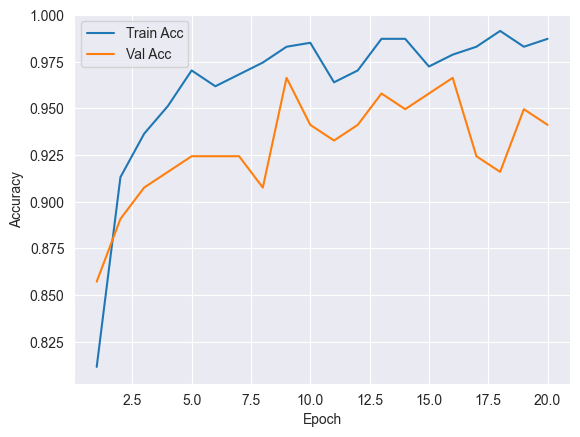

In [7]:
# Plot loss and accuracy curves
epochs = range(1, config['training']['epochs']+1)

plt.figure()
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Sauvegarde de la figure des coubres accuracy
fig_path = os.path.join(FIG_OUT, f"{run_id}_accuracy_curves.png")
plt.savefig(fig_path, dpi=300)
print("Courbes sauvegardées dans :", fig_path)

plt.show()

Courbes sauvegardées dans : ../outputs/figures/all/finetune_resnet18/2025-07-08_0ef9650_loss_curves.png


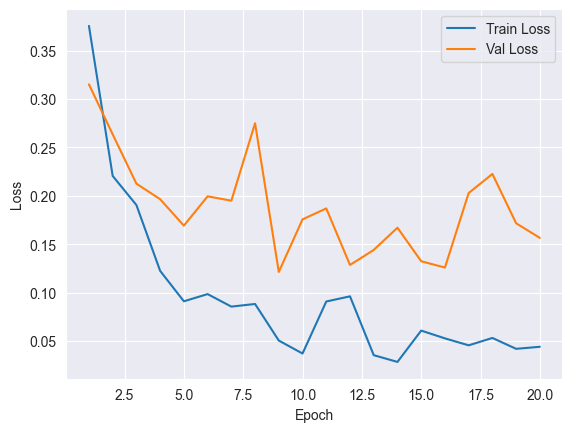

In [8]:
plt.figure()
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Sauvegarde de la figure des coubres loss
fig_path = os.path.join(FIG_OUT, f"{run_id}_loss_curves.png")
plt.savefig(fig_path, dpi=300)
print("Courbes sauvegardées dans :", fig_path)

plt.show()

ROC sauvegardées dans : ../outputs/figures/all/finetune_resnet18/2025-07-08_0ef9650_roc_curve.png


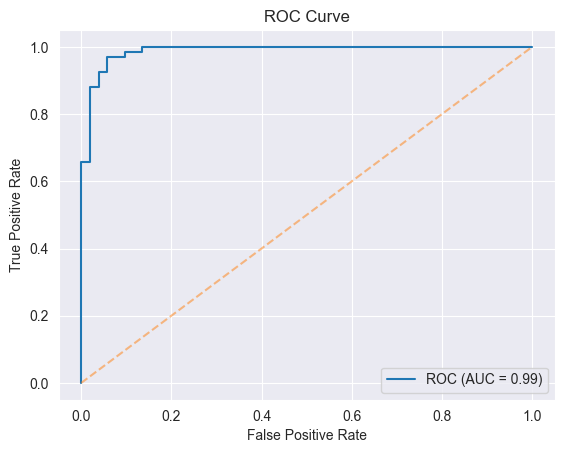

In [9]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_prob)
precision, recall, _ = precision_recall_curve(y_true, y_prob)
roc_auc_val = roc_auc_score(y_true, y_prob)
ap_val = average_precision_score(y_true, y_prob)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], '--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Sauvegarde de la figure d'ROC
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_roc_curve.png"))
print("ROC sauvegardées dans :", os.path.join(FIG_OUT, f"{run_id}_roc_curve.png"))
plt.show()

ROC sauvegardées dans : ../outputs/figures/all/finetune_resnet18/2025-07-08_0ef9650_pr_curve.png


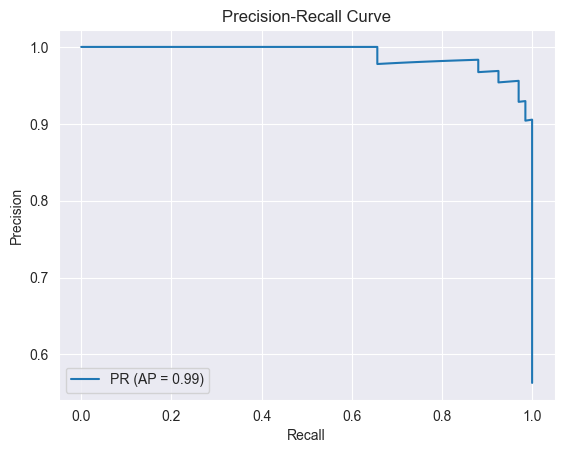

In [10]:
# Plot PR
plt.figure()
plt.plot(recall, precision, label=f'PR (AP = {ap_val:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.savefig(os.path.join(FIG_OUT, f"{run_id}_pr_curve.png"), dpi=300)
print("ROC sauvegardées dans :", os.path.join(FIG_OUT, f"{run_id}_pr_curve.png"))

plt.show()

Matrice sauvegardée dans : ../outputs/figures/all/finetune_resnet18/2025-07-08_0ef9650_confusion_matrix.png


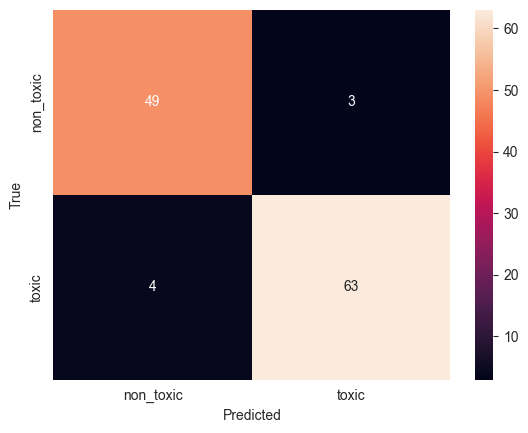

In [11]:
# Confusion matrix
target_names = dataset.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('True')
plt.xlabel('Predicted')

# Sauvegarde de la figure de confusion matrix
fig_path = os.path.join(FIG_OUT, f"{run_id}_confusion_matrix.png")
plt.savefig(fig_path, dpi=300)
print("Matrice sauvegardée dans :", fig_path)

plt.show()

Report CSV sauvegardé dans : ../outputs/figures/all/finetune_resnet18/2025-07-08_0ef9650_classification_report.csv
Report image sauvegardé dans : ../outputs/figures/all/finetune_resnet18/2025-07-08_0ef9650_classification_report.png


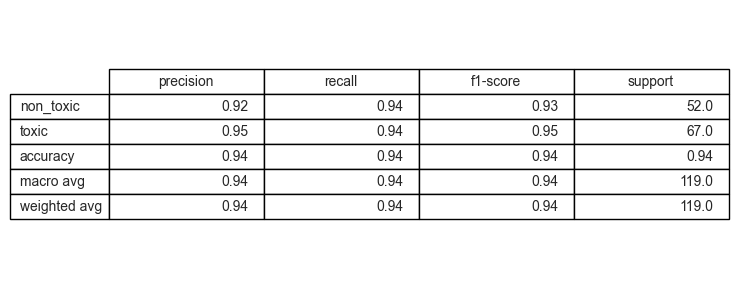

In [13]:
# Classification report
# print(classification_report(y_true, y_pred, target_names=target_names))

report_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=target_names, output_dict=True)).T

csv_path = os.path.join(FIG_OUT, f"{run_id}_classification_report.csv")
report_df.to_csv(csv_path, index=True)
print("Report CSV sauvegardé dans :", csv_path)

fig, ax = plt.subplots(figsize=(8, len(report_df) * 0.5 + 1))
ax.axis('off')

table = ax.table(
    cellText=report_df.round(2).values,
    rowLabels=report_df.index,
    colLabels=report_df.columns,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

img_path = os.path.join(FIG_OUT, f"{run_id}_classification_report.png")
fig.savefig(img_path, dpi=300, bbox_inches='tight')
print("Report image sauvegardé dans :", img_path)

## 6. Save Model & Config

In [14]:
os.makedirs('../outputs/checkpoints/all/finetune_resnet18', exist_ok=True)
torch.save(model.state_dict(), f'../outputs/checkpoints/all/finetune_resnet18/{run_id}_model.pth')

with open(f'../outputs/configs/all/{run_id}_config_finetune_resnet18.yaml', 'w') as f:
    yaml.dump(config, f)

print('Training complete. Model and config saved in outputs')

Training complete. Model and config saved in outputs


## 7. Grad-CAM Interpretability

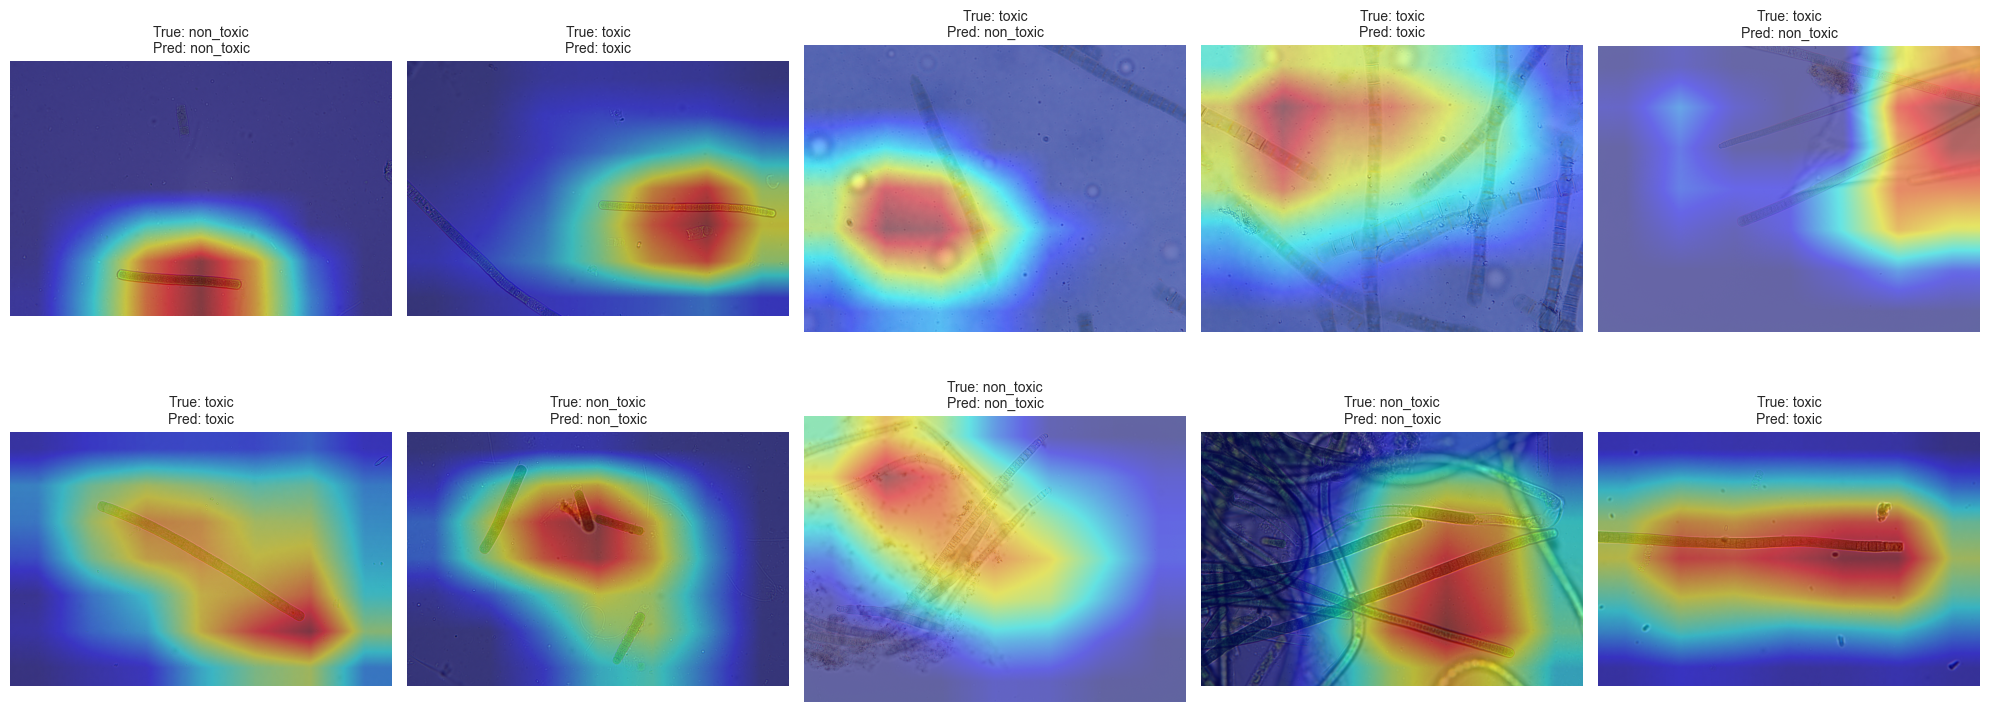

In [21]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

vis_transform = transforms.Compose([
    transforms.Resize(tuple(data_cfg['resize'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_cfg['normalization']['mean'], std=data_cfg['normalization']['std'])
])

target_layer = model.layer4[-1].conv2
cam_extractor = GradCAM(model=model, target_layers=[target_layer])

n_display = 10

n_cols = 5
n_rows = math.ceil(n_display / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols * 4, n_rows * 4),
                         dpi=100)
axes = axes.flatten()

for idx in range(n_display):
    ax = axes[idx]

    tensor_aug, true_label = val_set[idx]
    orig_path, _ = val_set.dataset.samples[val_set.indices[idx]]
    orig_img: Image.Image = Image.open(orig_path).convert('RGB')
    W, H = orig_img.size

    orig_resized = transforms.Resize(tuple(data_cfg['resize']))(orig_img)
    input_tensor = vis_transform(orig_resized).unsqueeze(0)

    outputs = model(input_tensor)
    pred_label = outputs.argmax(dim=1).item()

    grayscale_cam = cam_extractor(input_tensor=input_tensor)[0]

    cam_img = Image.fromarray((grayscale_cam * 255).astype(np.uint8))
    cam_img = cam_img.resize((W, H), resample=Image.BILINEAR)
    cam_resized = np.array(cam_img, dtype=np.float32) / 255.0

    rgb_orig = np.array(orig_img, dtype=np.float32) / 255.0
    cam_on_orig = show_cam_on_image(rgb_orig, cam_resized, use_rgb=True)

    ax.imshow(cam_on_orig)
    ax.set_title(f"True: {dataset.classes[true_label]}\nPred: {dataset.classes[pred_label]}",
                 fontsize=10)
    ax.axis('off')

for ax in axes[n_display:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
